In [1]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

15884


# 0. required packages for h5py

In [2]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'S:\puzheng\20201215-proB_DMSO_CTP-08',
             'save_folder':r'D:\Pu_Temp\20201215-proB_DMSO',
             #'save_folder':r'D:\Pu_Temp\202009_IgH_proB_DMSO_2color',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'Z:\Corrections\20210203-Corrections_3color_35',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,49)

In [4]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.583s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_03.hdf5
++ base attributes loaded:[] in 0.001s.
-- savi

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ finish loading unique in 0.063s. 
+ directly use current chromsome coordinates.
kept chromosomes: 313
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_04.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 3.148s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_04.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation fr

kept chromosomes: 279
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_06.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.593s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_06.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_06.hdf5
++ base attributes loaded

-- checking unique, region:[394 389 395] in 0.015s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_07.hdf5
++ finish loading unique in 0.031s. 
+ directly use current chromsome coordinates.
kept chromosomes: 354
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_08.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.828s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_08.hdf5
++ load bleed correction profile directly from savefile.
++ load ch

-- checking unique, region:[382 380 390] in 0.016s.
-- checking unique, region:[388 383 393] in 0.016s.
-- checking unique, region:[391 386 392] in 0.027s.
-- checking unique, region:[394 389 395] in 0.012s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_09.hdf5
++ finish loading unique in 0.029s. 
+ directly use current chromsome coordinates.
kept chromosomes: 368
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_10.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 

-- checking unique, region:[372 370 381] in 0.016s.
-- checking unique, region:[375 373 384] in 0.000s.
-- checking unique, region:[379 376 387] in 0.019s.
-- checking unique, region:[382 380 390] in 0.008s.
-- checking unique, region:[388 383 393] in 0.010s.
-- checking unique, region:[391 386 392] in 0.008s.
-- checking unique, region:[394 389 395] in 0.008s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_11.hdf5
++ finish loading unique in 0.031s. 
+ directly use current chromsome coordinates.
kept chromosomes: 351
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fo

-- checking unique, region:[382 380 390] in 0.016s.
-- checking unique, region:[388 383 393] in 0.016s.
-- checking unique, region:[391 386 392] in 0.016s.
-- checking unique, region:[394 389 395] in 0.000s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_13.hdf5
++ finish loading unique in 0.044s. 
+ directly use current chromsome coordinates.
kept chromosomes: 275
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_14.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 

-- checking unique, region:[366 364 374] in 0.016s.
-- checking unique, region:[369 367 377] in 0.000s.
-- checking unique, region:[372 370 381] in 0.022s.
-- checking unique, region:[375 373 384] in 0.008s.
-- checking unique, region:[379 376 387] in 0.008s.
-- checking unique, region:[382 380 390] in 0.008s.
-- checking unique, region:[388 383 393] in 0.002s.
-- checking unique, region:[391 386 392] in 0.014s.
-- checking unique, region:[394 389 395] in 0.016s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_15.hdf5
++ finish loading unique in 0.031s. 
+ directly use current chromsome coordinates.
kept chromosomes: 370
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this d

-- checking unique, region:[332 330 341] in 0.016s.
-- checking unique, region:[335 333 344] in 0.017s.
-- checking unique, region:[339 337 347] in 0.016s.
-- checking unique, region:[342 340 350] in 0.015s.
-- checking unique, region:[345 343 353] in 0.015s.
-- checking unique, region:[348 346 356] in 0.017s.
-- checking unique, region:[351 349 359] in 0.010s.
-- checking unique, region:[354 352 362] in 0.005s.
-- checking unique, region:[357 355 365] in 0.014s.
-- checking unique, region:[360 358 368] in 0.016s.
-- checking unique, region:[363 361 371] in 0.000s.
-- checking unique, region:[366 364 374] in 0.016s.
-- checking unique, region:[369 367 377] in 0.000s.
-- checking unique, region:[372 370 381] in 0.016s.
-- checking unique, region:[375 373 384] in 0.000s.
-- checking unique, region:[379 376 387] in 0.016s.
-- checking unique, region:[382 380 390] in 0.000s.
-- checking unique, region:[388 383 393] in 0.016s.
-- checking unique, region:[391 386 392] in 0.000s.
-- checking 

-- checking unique, region:[326 324 331] in 0.016s.
-- checking unique, region:[329 327 334] in 0.022s.
-- checking unique, region:[332 330 341] in 0.011s.
-- checking unique, region:[335 333 344] in 0.014s.
-- checking unique, region:[339 337 347] in 0.000s.
-- checking unique, region:[342 340 350] in 0.023s.
-- checking unique, region:[345 343 353] in 0.008s.
-- checking unique, region:[348 346 356] in 0.008s.
-- checking unique, region:[351 349 359] in 0.009s.
-- checking unique, region:[354 352 362] in 0.008s.
-- checking unique, region:[357 355 365] in 0.008s.
-- checking unique, region:[360 358 368] in 0.007s.
-- checking unique, region:[363 361 371] in 0.006s.
-- checking unique, region:[366 364 374] in 0.000s.
-- checking unique, region:[369 367 377] in 0.015s.
-- checking unique, region:[372 370 381] in 0.000s.
-- checking unique, region:[375 373 384] in 0.016s.
-- checking unique, region:[379 376 387] in 0.031s.
-- checking unique, region:[382 380 390] in 0.000s.
-- checking 

-- checking unique, region:[108 109 110] in 0.016s.
-- checking unique, region:[111 112 113] in 0.000s.
-- checking unique, region:[114 115 325] in 0.015s.
-- checking unique, region:[323 321 328] in 0.013s.
-- checking unique, region:[326 324 331] in 0.008s.
-- checking unique, region:[329 327 334] in 0.008s.
-- checking unique, region:[332 330 341] in 0.007s.
-- checking unique, region:[335 333 344] in 0.008s.
-- checking unique, region:[339 337 347] in 0.008s.
-- checking unique, region:[342 340 350] in 0.008s.
-- checking unique, region:[345 343 353] in 0.007s.
-- checking unique, region:[348 346 356] in 0.007s.
-- checking unique, region:[351 349 359] in 0.005s.
-- checking unique, region:[354 352 362] in 0.000s.
-- checking unique, region:[357 355 365] in 0.014s.
-- checking unique, region:[360 358 368] in 0.000s.
-- checking unique, region:[363 361 371] in 0.016s.
-- checking unique, region:[366 364 374] in 0.000s.
-- checking unique, region:[369 367 377] in 0.016s.
-- checking 

-- checking unique, region:[93 94 95] in 0.017s.
-- checking unique, region:[96 97 98] in 0.014s.
-- checking unique, region:[ 99 100 101] in 0.025s.
-- checking unique, region:[102 103 104] in 0.007s.
-- checking unique, region:[105 106 107] in 0.000s.
-- checking unique, region:[108 109 110] in 0.016s.
-- checking unique, region:[111 112 113] in 0.014s.
-- checking unique, region:[114 115 325] in 0.000s.
-- checking unique, region:[323 321 328] in 0.017s.
-- checking unique, region:[326 324 331] in 0.007s.
-- checking unique, region:[329 327 334] in 0.007s.
-- checking unique, region:[332 330 341] in 0.008s.
-- checking unique, region:[335 333 344] in 0.008s.
-- checking unique, region:[339 337 347] in 0.000s.
-- checking unique, region:[342 340 350] in 0.014s.
-- checking unique, region:[345 343 353] in 0.000s.
-- checking unique, region:[348 346 356] in 0.016s.
-- checking unique, region:[351 349 359] in 0.016s.
-- checking unique, region:[354 352 362] in 0.016s.
-- checking unique

-- checking unique, region:[323 321 328] in 0.016s.
-- checking unique, region:[326 324 331] in 0.000s.
-- checking unique, region:[329 327 334] in 0.017s.
-- checking unique, region:[332 330 341] in 0.006s.
-- checking unique, region:[335 333 344] in 0.006s.
-- checking unique, region:[339 337 347] in 0.007s.
-- checking unique, region:[342 340 350] in 0.007s.
-- checking unique, region:[345 343 353] in 0.010s.
-- checking unique, region:[348 346 356] in 0.006s.
-- checking unique, region:[351 349 359] in 0.005s.
-- checking unique, region:[354 352 362] in 0.000s.
-- checking unique, region:[357 355 365] in 0.016s.
-- checking unique, region:[360 358 368] in 0.000s.
-- checking unique, region:[363 361 371] in 0.014s.
-- checking unique, region:[366 364 374] in 0.000s.
-- checking unique, region:[369 367 377] in 0.000s.
-- checking unique, region:[372 370 381] in 0.000s.
-- checking unique, region:[375 373 384] in 0.000s.
-- checking unique, region:[379 376 387] in 0.016s.
-- checking 

-- checking unique, region:[323 321 328] in 0.016s.
-- checking unique, region:[326 324 331] in 0.000s.
-- checking unique, region:[329 327 334] in 0.016s.
-- checking unique, region:[332 330 341] in 0.009s.
-- checking unique, region:[335 333 344] in 0.010s.
-- checking unique, region:[339 337 347] in 0.005s.
-- checking unique, region:[342 340 350] in 0.005s.
-- checking unique, region:[345 343 353] in 0.009s.
-- checking unique, region:[348 346 356] in 0.008s.
-- checking unique, region:[351 349 359] in 0.007s.
-- checking unique, region:[354 352 362] in 0.006s.
-- checking unique, region:[357 355 365] in 0.008s.
-- checking unique, region:[360 358 368] in 0.008s.
-- checking unique, region:[363 361 371] in 0.005s.
-- checking unique, region:[366 364 374] in 0.006s.
-- checking unique, region:[369 367 377] in 0.005s.
-- checking unique, region:[372 370 381] in 0.002s.
-- checking unique, region:[375 373 384] in 0.000s.
-- checking unique, region:[379 376 387] in 0.014s.
-- checking 

-- checking unique, region:[369 367 377] in 0.016s.
-- checking unique, region:[372 370 381] in 0.000s.
-- checking unique, region:[375 373 384] in 0.000s.
-- checking unique, region:[379 376 387] in 0.016s.
-- checking unique, region:[382 380 390] in 0.000s.
-- checking unique, region:[388 383 393] in 0.000s.
-- checking unique, region:[391 386 392] in 0.016s.
-- checking unique, region:[394 389 395] in 0.007s.
directly return existing attribute.
+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_29.hdf5
++ finish loading unique in 0.032s. 
+ directly use current chromsome coordinates.
kept chromosomes: 430
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are fou

+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_31.hdf5
++ finish loading unique in 0.033s. 
+ directly use current chromsome coordinates.
kept chromosomes: 383
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_32.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.578s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_32.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illu

+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_33.hdf5
++ finish loading unique in 0.031s. 
+ directly use current chromsome coordinates.
kept chromosomes: 322
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_34.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.511s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_34.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correctio

++ finish loading unique in 0.037s. 
+ directly use current chromsome coordinates.
kept chromosomes: 431
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_36.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.500s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_36.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation fr

+ directly use current chromsome coordinates.
kept chromosomes: 445
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_38.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.559s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_38.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMS

kept chromosomes: 446
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_40.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.719s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_40.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_40.hdf5
++ base attributes loaded

++ finish loading unique in 0.044s. 
+ directly use current chromsome coordinates.
kept chromosomes: 375
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_42.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.547s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_42.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation fr

kept chromosomes: 455
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_44.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.563s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_44.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_44.hdf5
++ base attributes loaded

kept chromosomes: 376
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_46.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.594s.
+ loading correction from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_46.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_46.hdf5
++ base attributes loaded

+ directly use current chromsome coordinates.
+ loading unique from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_47.hdf5
++ finish loading unique in 0.040s. 
+ directly use current chromsome coordinates.
kept chromosomes: 344
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 49
- Number of field of views: 63
- Importing csv file: S:\puzheng\20201215-proB_DMSO_CTP-08\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 49 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_48.hdf5


OSError: Unable to create file (unable to open file: name = 'D:\Pu_Temp\20201215-proB_DMSO\Conv_zscan_48.hdf5', errno = 17, error message = 'File exists', flags = 15, o_flags = 502)

In [6]:
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

17229 are found.


In [37]:
cand_chr_spots_list[0][2][:,0] / cand_chr_spots_list[0][2][:,4]


array([1.3280632 , 0.40055022, 0.22331731, 0.36319655, 0.13868658,
       0.23065217, 0.16548814, 0.22743136], dtype=float32)

In [36]:
cand_chr_spots_list[0][1][:,0] / cand_chr_spots_list[0][1][:,4]


array([1.765041  , 0.98329663, 0.41745123, 0.37771517, 0.254543  ,
       0.30919972], dtype=float32)

In [38]:
sel_dna_hzxys_list[-1][0]

array([[ 1836.7746582 ,  1264.65771484, 14387.89355469, 58191.59375   ],
       [ 1724.47351074,  1083.86486816, 14370.28027344, 57946.69921875],
       [ 1129.08239746,   934.14916992, 14387.23144531, 57851.83203125],
       [  459.12054443,  1032.38818359, 14368.93359375, 57967.734375  ],
       [ 1868.91162109,  1032.73400879, 14400.73730469, 57939.5546875 ],
       [  777.64916992,  3173.22021484, 12998.39550781, 59585.01953125],
       [  300.00234985,  1060.66357422, 14221.43554688, 58096.73046875],
       [  775.58380127,  1028.56335449, 14271.56152344, 58044.71875   ],
       [  451.62582397,  1476.53393555, 14509.68652344, 58488.05078125],
       [  339.52612305,  1054.68688965, 14328.3828125 , 58143.1796875 ],
       [  639.58087158,  1039.17565918, 14519.36914062, 57976.7265625 ],
       [  880.06378174,  1065.3236084 , 14569.35449219, 57904.921875  ],
       [  487.56219482,  1060.98510742, 14445.53027344, 58203.27734375],
       [ 2530.32128906,  1079.78540039, 14660.45117

In [39]:
cand_chr_spots_list[0][0][:,0]

array([1836.7747 , 1432.7665 ,  125.00636], dtype=float32)

In [35]:
cand_chr_spots_list[0][0][:,0] / cand_chr_spots_list[0][0][:,4]


array([2.35444  , 1.9400469, 0.3139552], dtype=float32)

In [8]:
# select_hzxys close to the chromosome center
dist_th = 5000 # upper limit is 5000nm
intensity_th = 200
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 216.336s
-- collapse all regions into 1d.


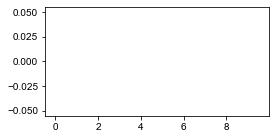

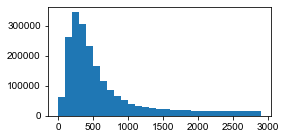

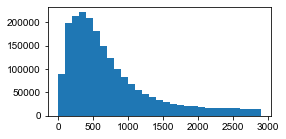

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 103.630s
-- region kept: 0.7981
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 76.047s
-- collapse all regions into 1d.


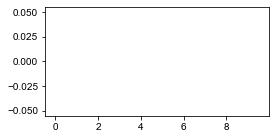

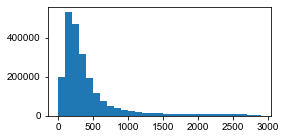

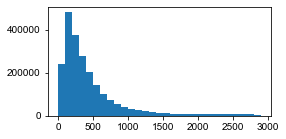

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 103.708s
-- region kept: 0.9427
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 75.906s
-- collapse all regions into 1d.


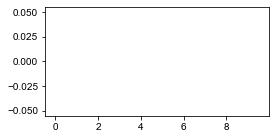

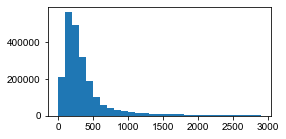

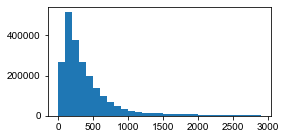

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 104.826s
-- region kept: 0.9778
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 74.718s
-- collapse all regions into 1d.


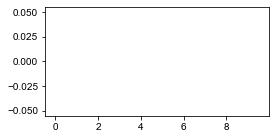

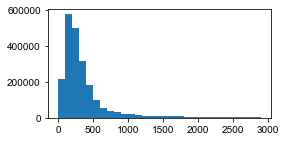

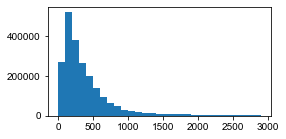

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 104.684s
-- region kept: 0.9868
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 76.572s
-- collapse all regions into 1d.


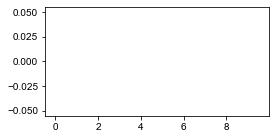

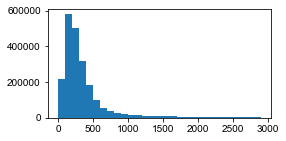

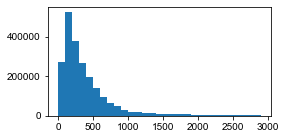

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 105.102s
-- region kept: 0.9870
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 76.522s
-- collapse all regions into 1d.


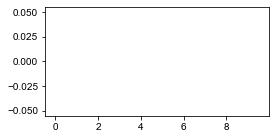

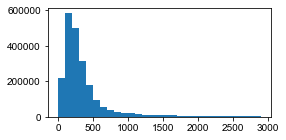

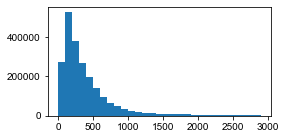

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 104.609s
-- region kept: 0.9893
- iter:6
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 77.340s
-- collapse all regions into 1d.


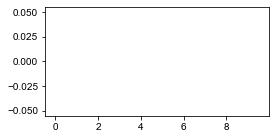

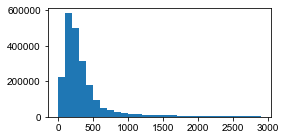

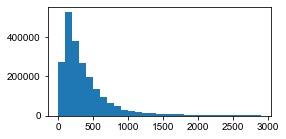

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 105.068s
-- region kept: 0.9886
- iter:7
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 76.864s
-- collapse all regions into 1d.


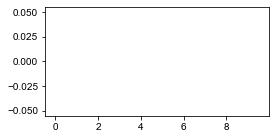

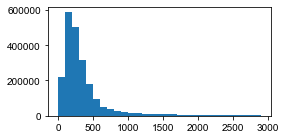

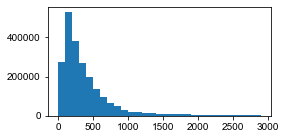

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 103.532s
-- region kept: 0.9888
- iter:8
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 77.833s
-- collapse all regions into 1d.


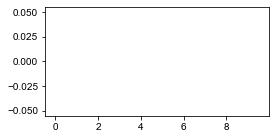

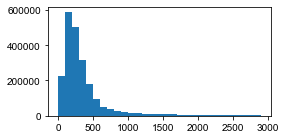

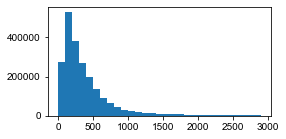

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 103.418s
-- region kept: 0.9901
- iter:9
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 74.606s
-- collapse all regions into 1d.


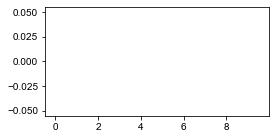

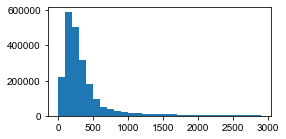

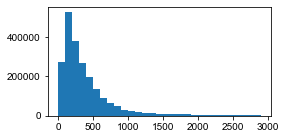

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 103.391s
-- region kept: 0.9904


In [9]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

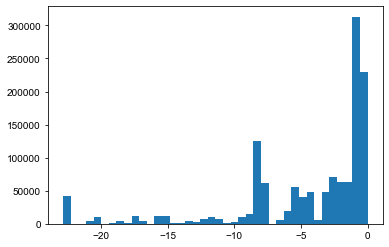

In [25]:
plt.figure()
plt.hist(np.log(np.ravel(sel_dna_scores_list[-1][:10000])), 40)
plt.show()

In [20]:
len(sel_dna_scores_list[-1])

17229

In [24]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-10)
int_th = 500
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    #_kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

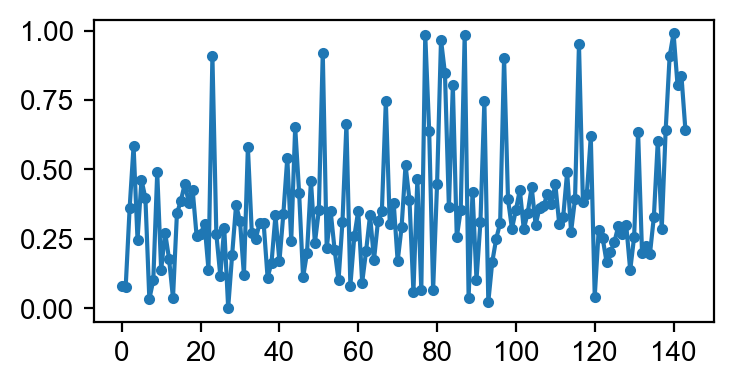

In [26]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [27]:
kept_inds = np.where(loss_rates<0.5)[0]

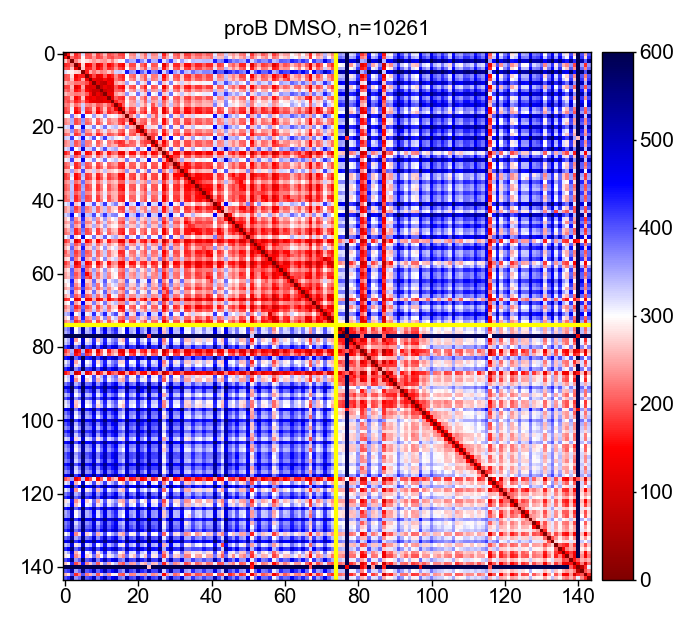

In [52]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.axvline(x=74, color=[1,1,0])
ax.axhline(y=74, color=[1,1,0])
ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
plt.show()

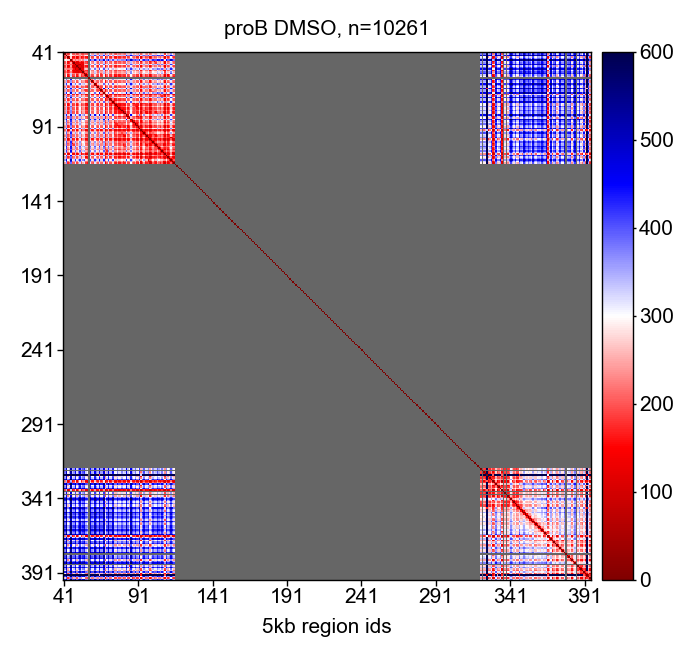

In [96]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

In [54]:
dna_reg_ids-np.min(dna_reg_ids)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74, 280, 282, 283, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 338, 339,
       340, 341, 342, 343, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354])

###### 

# quality check

In [125]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _ind = list(_grp['ids'][:]).index(41)
    _im = _grp['ims'][_ind]
    sel_drifts = _grp['drifts'][:,:]
    sel_flags = _grp['flags'][:]
    sel_ids = _grp['ids'][:]
    sel_spots = _grp['spots'][:,:,:]
    print(_ind, np.sum(_grp['spots'][1]))

0 3826469.0


In [58]:
fov.unique_spots_list[100]

array([[ 6.56082726e+00,  2.59606991e+01,  6.11601379e+02, ...,
         7.73071229e-01, -3.07731796e-02,  1.70267914e+02],
       [ 4.22157383e+00,  2.32151070e+01,  9.43703918e+02, ...,
         4.81479615e-01,  6.38460398e-01,  1.23589035e+02],
       [ 3.96723986e+00,  2.77801933e+01,  7.93457642e+02, ...,
         7.53727496e-01,  9.04093564e-01,  1.02488930e+02],
       ...,
       [ 1.36868820e-01,  2.36938343e+01,  5.36140991e+02, ...,
         1.00000000e+00,  1.00000000e+00,  3.58169556e+01],
       [ 1.75873071e-01,  1.39472771e+01,  1.97251758e+03, ...,
        -2.08728582e-01, -6.80764616e-02,  3.75798035e+01],
       [ 1.79312319e-01,  2.28999996e+01,  8.71613098e+02, ...,
        -1.00000000e+00, -1.00000000e+00,  3.54034157e+01]], dtype=float32)

<IPython.core.display.Javascript object>


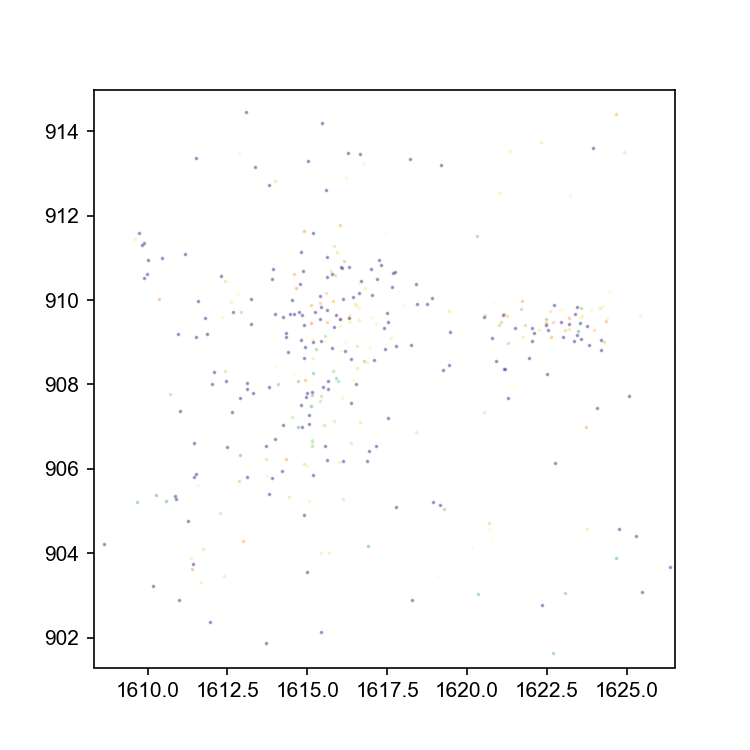

In [145]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)
for _id,_s in zip(sel_ids, kept_spots_list):
    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
plt.ylim([0,2048])
plt.xlim([0,2048])
#plt.legend()
plt.show()

array([[0.98592849, 0.63737024, 0.35963091, 1.        ],
       [0.98869666, 0.65736255, 0.36885813, 1.        ],
       [0.99146482, 0.67735486, 0.37808535, 1.        ],
       [0.99238754, 0.69388697, 0.39008074, 1.        ],
       [0.99269512, 0.70926567, 0.40299885, 1.        ],
       [0.9928489 , 0.71695502, 0.4094579 , 1.        ],
       [0.99315648, 0.73233372, 0.42237601, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.99377163, 0.76309112, 0.44821223, 1.        ],
       [0.99392541, 0.77078047, 0.45467128, 1.        ],
       [0.99423299, 0.78615917, 0.46758939, 1.        ],
       [0.99454056, 0.80153787, 0.4805075 , 1.        ],
       [0.99484814, 0.81691657, 0.49342561, 1.        ],
       [0.99515571, 0.83229527, 0.50634371, 1.        ],
       [0.9953095 , 0.83998462, 0.51280277, 1.        ],
       [0.99561707, 0.85536332, 0.52572088, 1.        ],
       [0.99592464, 0.87074202, 0.53863899, 1.        ],
       [0.99638601, 0.88796617,

## visualize pciked hzxys

<IPython.core.display.Javascript object>


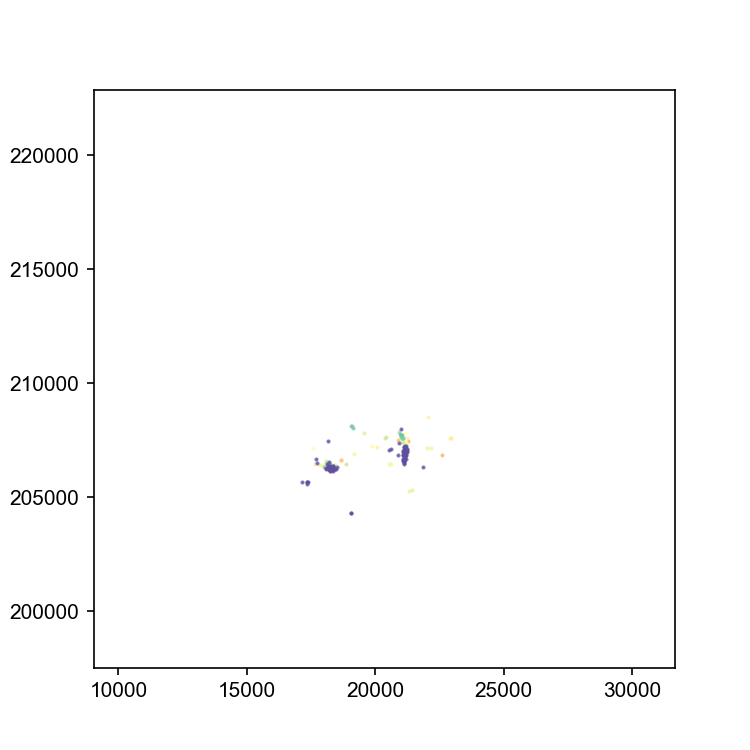

In [146]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)

for _i, _id in enumerate(sel_ids):
    plt.plot([_spots[_i,2] for _spots in final_dna_hzxys_list],
             [_spots[_i,3] for _spots in final_dna_hzxys_list],
             '.', markersize=2, color=Spectral(_id/(len(sel_ids)+1)), alpha=0.7)
#for _id,_s in zip(sel_ids, kept_spots_list):
#    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
#             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
#plt.ylim([0,2048])
#plt.xlim([0,2048])
#plt.legend()
plt.show()

## visualize fitted spots

<IPython.core.display.Javascript object>


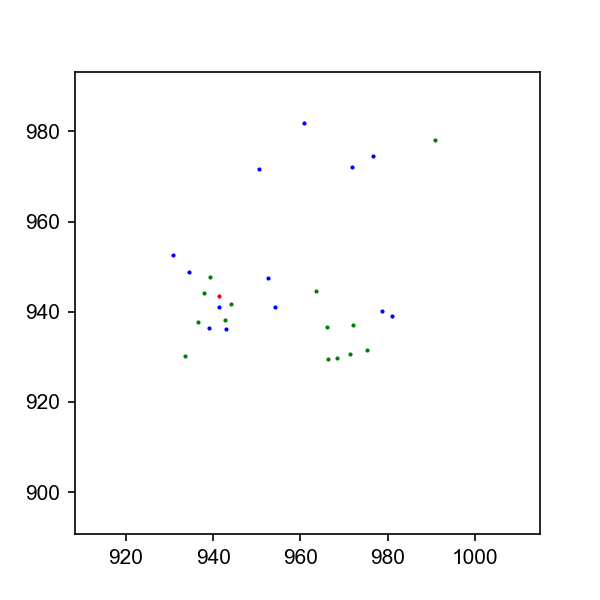

In [28]:
plt.figure(figsize=(4,4),dpi=150)
plt.plot(fov.chrom_coords[:,1], fov.chrom_coords[:,2], 'r.', markersize=2)
plt.plot(fov.unique_spots_list[0][:,2], fov.unique_spots_list[0][:,3], 'b.', markersize=2)
plt.plot(fov.unique_spots_list[-1][:,2], fov.unique_spots_list[-1][:,3], 'g.', markersize=2)

In [84]:
sel_drifts[kept_inds]

array([[ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2

In [86]:
sel_drifts[kept_inds]

array([[  0.46, -16.34,  16.85],
       [  0.46, -16.34,  16.85],
       [  0.44,  -8.16,  14.05],
       [  0.44,  -8.16,  14.05],
       [  2.29,  -2.57,  15.59],
       [  2.29,  -2.57,  15.59],
       [  2.35,   8.53,  14.83],
       [  2.35,   8.53,  14.83],
       [  2.31,   6.76,  13.09],
       [  2.31,   6.76,  13.09],
       [  0.44, -15.23,  17.16],
       [  0.44, -15.23,  17.16],
       [  2.33, -16.8 ,  17.91],
       [  2.33, -16.8 ,  17.91],
       [  0.46, -16.95,  17.39],
       [  0.46, -16.95,  17.39],
       [  0.44, -18.39,  20.26],
       [  0.44, -18.39,  20.26],
       [  0.42, -18.18,  18.52],
       [  0.42, -18.18,  18.52],
       [  0.41, -18.32,  17.25],
       [  0.41, -18.32,  17.25],
       [  0.41, -17.91,  18.16],
       [  0.41, -17.91,  18.16],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.62,  16.99],
       [  0.41, -18.62,  16.99],
       [  0.42, -18.41,  17.88],
       [  0.42, -18.41,  17.88],
       [  

In [93]:
fov.fov_id

5

In [118]:
pickle.load(open(fov.drift_filename, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '\\\\10.245.74.158\\Chromatin_NAS_6\\20201002-B_dox-IAA-STI+_CTP-08_IgH\\Analysis\\drift\\Conv_zscan_05_current_cor.pkl'

In [101]:
bead_im, _ = io_tools.load.correct_fov_image(os.path.join(fov.data_folder[0], 'H29R29\\Conv_zscan_05.dax'), 
                                             [fov.channels[fov.bead_channel_index]],
                                             correction_folder=fov.correction_folder,
                                             single_im_size=fov.shared_parameters['single_im_size'],
                                             all_channels=fov.channels,
                                             illumination_corr=True, 
                                             warp_image=False, calculate_drift=False, return_drift=False,
                                             verbose=True,
                                             )

- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax  in 8.028s
-- removing hot pixels for channels:['488'] in 7.301s
-- illumination correction for channels: 488, in 1.663s
-- generate translation function for chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.001s
-- finish correction in 17.336s


In [109]:
correction_tools.alignment.cross_correlation_align_single_image(bead_im[0], fov.ref_im,
                                                                single_im_size=fov.shared_parameters['single_im_size'])

-- aligning image -> directly use image
-- directly use ref_image


array([-0.09, -9.87,  6.47])

<IPython.core.display.Javascript object>


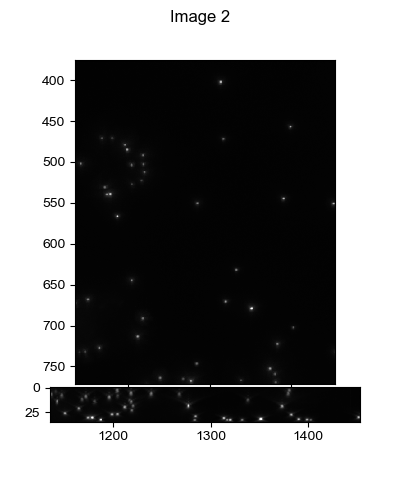

In [106]:
visual_tools.imshow_mark_3d_v2([bead_im[0], fov.ref_im])